In [1]:
    %reload_ext pidgin

'    %reload_ext pidgin'

## Current

Working on the __November__ progress which we plan to discuss next week.

This week we will review the work in VegaLite and the UDF research.

In [2]:
# Extracting Vega Lite Transformations

'# Extracting Vega Lite Transformations'

In [3]:
digraph {
    rankdir=LR
    subgraph cluster_js{label=JS VegaLite->JupyterComms->ExtractTransform->FrontEnd }
    Ibis->DataFrame[label="Empty DataFrame for type information"]
    DataFrame->Altair[label="Compose visualization"]
    ExtractTransform->UpdatedVegaLite->{FrontEnd UpdatedIbis}
    UpdatedIbis->Ibis
    Altair->VegaLite
    VegaLite
}

'digraph {\n    rankdir=LR\n    subgraph cluster_js{label=JS VegaLite->JupyterComms->ExtractTransform->FrontEnd }\n    Ibis->DataFrame[label="Empty DataFrame for type information"]\n    DataFrame->Altair[label="Compose visualization"]\n    ExtractTransform->UpdatedVegaLite->{FrontEnd UpdatedIbis}\n    UpdatedIbis->Ibis\n    Altair->VegaLite\n    VegaLite\n}'

In [4]:
## Omnisci UDFs

* https://docs.google.com/document/d/1iqG9gxa-baolsqt5U7T9OLhqFdNj5Ar8PDbFmG6Gscg/edit
* https://github.com/omnisci/mapd-core/pull/290/files

'## Omnisci UDFs\n\n* https://docs.google.com/document/d/1iqG9gxa-baolsqt5U7T9OLhqFdNj5Ar8PDbFmG6Gscg/edit\n* https://github.com/omnisci/mapd-core/pull/290/files'

In [5]:
    !more "../../mapd-core/python/example1.py"

"""Examples of mapd UDFs - a prototype

To run this script, the remotedict and mapd_server services must be up
and running. For example:

# In terminal 1, run
python /path/to/git/mapd-core/python/remotedict_server.py
# in terminal 2, run
export PYTHONPATH=/path/to/git/mapd-core/python
/path/to/bin/mapd_server
# in terminal 3, run
export PYTHONPATH=/path/to/git/mapd-core/python

# first time, numba.cfunc is applied to udf-s, may take more time

python /path/to/git/mapd-core/python/example1.py 

Executing query=`SELECT dest_merc_y FROM flights_2008_10k`
        elapsed time first time= 0.8853063583374023
        elapsed time second time= 0.0868997573852539
Executing query=`SELECT pyudf_d_d(-4142173805074969890, dest_merc_y) FROM flights_2008_10k`
        elapsed time first time= 0.5644011497497559
        elapsed time second time= 0.07272768020629883
Executing query=`SELECT dest_merc_y, dest_merc_y FROM flights_2008_10k`
        elapsed time first time= 0.1111757755279541
        elapsed

'    !more "../../mapd-core/python/example1.py"'

# Extracting Vega Lite Transformations

In this notebook, I will show some use cases for extracting out the [transformations](https://vega.github.io/vega-lite/docs/transform.html) in a Vega Lite spec and moving their computation to the MapD database from the client. 

To demonstrate this functionality, we recreate the examples the Vega Lite team used to demonstrate this feature: https://vega.github.io/vega-lite-transforms2sql/


## Install

First, we have to install the `omnisci_renderer` package, as well as altair, ibis and the MapD client. We need to install a development branch of ibis until https://github.com/ibis-project/ibis/pull/1675 is released.

In [6]:
    import altair as alt
    import ibis
    import omnisci_renderer

C:\Anaconda3\lib\site-packages\ibis\sql\postgres\compiler.py:223: UserWarning: locale specific date formats (%c, %x, %X) are not yet implemented for Windows
  'for %s' % platform.system()


'    import altair as alt\n    import ibis\n    import omnisci_renderer'

## Carrier names

Let's recreate the first example, counting the carrier names.

First we connect to thte table using Ibis:

In [7]:
    conn = ibis.mapd.connect(
        host='metis.mapd.com', user='mapd', password='HyperInteractive',
        port=443, database='mapd', protocol= 'https'
    )
    t = conn.table("flights_donotmodify")

'    conn = ibis.mapd.connect(\n        host=\'metis.mapd.com\', user=\'mapd\', password=\'HyperInteractive\',\n        port=443, database=\'mapd\', protocol= \'https\'\n    )\n    t = conn.table("flights_donotmodify")'

Then we compose an Altair chart using an ibis expression.

In [8]:
    c = alt.Chart(t[t.carrier_name]).mark_bar().encode(
        x='carrier_name',
        y='count()'
    )

"    c = alt.Chart(t[t.carrier_name]).mark_bar().encode(\n        x='carrier_name',\n        y='count()'\n    )"

Finally, we enable rendering that extracts the aggregate expressions and adds them onto the Ibis expresion:

In [9]:
    alt.data_transformers.enable('ibis')
    alt.renderers.enable("extract-ibis")
    c

C:\Anaconda3\lib\site-packages\altair\utils\core.py:86: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


'    alt.data_transformers.enable(\'ibis\')\n    alt.renderers.enable("extract-ibis")\n    c'

## Delay by Month

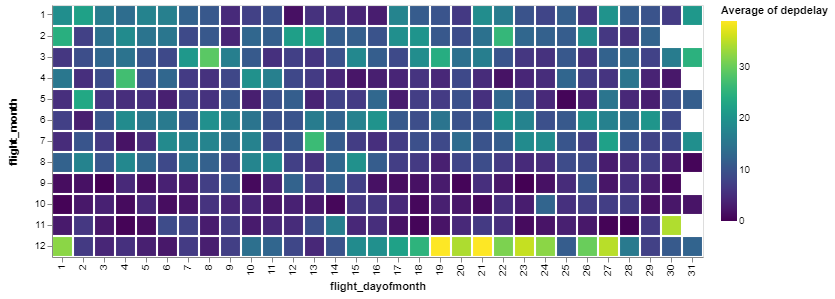

"    delay_by_month = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(\n        x='flight_dayofmonth:O',\n        y='flight_month:O',\n        color='average(depdelay)'\n    )\n    delay_by_month"

In [10]:
    delay_by_month = alt.Chart(t[t.flight_dayofmonth, t.flight_month, t.depdelay]).mark_rect().encode(
        x='flight_dayofmonth:O',
        y='flight_month:O',
        color='average(depdelay)'
    )
    delay_by_month

## Debugging

We can use `display_chart` to show some intermediate computatitons for the chart. It does this by enabling different Altair renderers and displaying the chart:

In [11]:
    ??omnisci_renderer.display_chart

'    ??omnisci_renderer.display_chart'

Signature: omnisci_renderer.display_chart(chart)
Docstring: <no docstring>
Source:   
def display_chart(chart):
    display(Code('alt.renderers.enable("json")'))
    alt.renderers.enable("json")
    display(chart)

    display(Code('alt.renderers.enable("extract-json")'))
    alt.renderers.enable("extract-json")
    chart._repr_mimebundle_(None, None)

    display(Code('alt.renderers.enable("extract-ibis-sql")'))
    alt.renderers.enable("extract-ibis-sql")
    chart._repr_mimebundle_(None, None)

    display(Code('alt.renderers.enable("extract-ibis")'))
    alt.renderers.enable("extract-ibis")
    chart._repr_mimebundle_(None, None)
File:      c:\users\deathbeds\jupyterlab-omnisci\omnisci_renderer.py
Type:      function

In [12]:
    omnisci_renderer.display_chart(c)

alt.renderers.enable("json")

C:\Anaconda3\lib\site-packages\altair\utils\core.py:86: UserWarning: I don't know how to infer vegalite type from 'empty'.  Defaulting to nominal.
  "Defaulting to nominal.".format(typ))


<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


alt.renderers.enable("extract-json")

<IPython.core.display.JSON object>

alt.renderers.enable("extract-ibis-sql")

SELECT "carrier_name", count(*) AS count_*
FROM (
  SELECT "carrier_name"
  FROM flights_donotmodify
) t0
GROUP BY carrier_name

alt.renderers.enable("extract-ibis")

'    omnisci_renderer.display_chart(c)'

In [13]:
    omnisci_renderer.display_chart(delay_by_month)

alt.renderers.enable("json")

<VegaLite 2 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


alt.renderers.enable("extract-json")

<IPython.core.display.JSON object>

alt.renderers.enable("extract-ibis-sql")

SELECT "flight_dayofmonth", "flight_month",
       avg("depdelay") AS average_depdelay
FROM (
  SELECT "flight_dayofmonth", "flight_month", "depdelay"
  FROM flights_donotmodify
) t0
GROUP BY flight_dayofmonth, flight_month

alt.renderers.enable("extract-ibis")

'    omnisci_renderer.display_chart(delay_by_month)'